## Cell Lineage in the adult mouse corpus callosum

This notebook demonstrates how to recreate lineages published in the paper [Live imaging of remyelination in the adult mouse corpus callosum](https://www.pnas.org/content/118/28/e2025795118) and available at [idr0113-bottes-opcclones](https://idr.openmicroscopy.org/search/?query=Name:idr0113).

The lineage is created from the metadata associated to the specified image.

To load the data from the Image Data Resource, we use:
* the [Python API](https://docs.openmicroscopy.org/omero/latest/developers/Python.html)
* the [JSON API](https://docs.openmicroscopy.org/omero/latest/developers/json-api.html)

LPC-induced focal demyelination and in vivo imaging of genetically targeted OPCs and their progeny to describe the cellular dynamics of OPC-mediated remyelination in the CC.

Longitudinal observation of OPCs and their progeny for up to two months reveals functional inter- and intraclonal heterogeneity and provides insights into the cell division capacity and the migration/differentiation dynamics of OPCs and their daughter cells in vivo.

The majority of the clones remained quiescent or divided only few times. Some OPCs were highly proliferative. 
Large clones showed longer times between consecutive divisions compared to low proliferating clones.

OPCs show distinct modes of cell division: from symmetric proliferative, to symmetric differentiating and also asymmetric cell division, where the OPC is self-renewed while the other daughter cell differentiates.

Only 16.46% of OPC-derived cells differentiated into mature, remyelinating oligodendrocytes, with OPCs born at early divisions showing a higher probability to survive and to terminally differentiate.

Cell death was associated with distinct cell division histories of different clones, with higher probability of death when generated at later divisions.

Migratory behaviour was restricted to progenitors. Successfully differentiating progenitors moved shorter distances per day compared to dying cells.

## Settings

### Auxiliar libraries used
* [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
* [jupyter_contrib_nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html): Package containing a collection of community-contributed unofficial extensions that add functionality to the Jupyter notebook
* [jupyter-notebookparams](https://pypi.org/project/jupyter-notebookparams/): Takes query parameters from a url to update a parameter cell of a jupyter notebook.

## Launch

### binder

If not already running, you can launch by clicking on the logo [![Binder <](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/IDR/idr0113-bottes-opcclones/main?urlpath=notebooks%2Fnotebooks%2Fidr0113_lineage.ipynb%3FimageId%3D13425213)

### run locally using repo2docker

With ``jupyter-repo2docker`` installed, run:
```
git clone https://github.com/IDR/idr0113-bottes-opcclones.git
cd idr0113-bottes-opcclones
repo2docker .
```

## Collect the parameter 

In [1]:
# Parameters:
imageId = 13425213

## Load the libraries 

In [2]:
import graphviz
import math
import requests
import pandas as pd

from os.path import expanduser

from idr import connection

# Load data 

## Connect to IDR

In [3]:
conn = connection('idr.openmicroscopy.org')

Connected to IDR ...


## Load the plane information
First load information about the image so we can identify the number of days after induction.

In [4]:
times = {}

image = conn.getObject("Image", imageId)
pixels_id = image.getPrimaryPixels().getId()
query = "from PlaneInfo as Info where pixels.id='" + str(pixels_id) + "'"
infos = conn.getQueryService().findAllByQuery(query, None)
for i in infos:
    times.update({i.theT.getValue(): int(i.deltaT.getValue())})

## URL used to load data
We now use the JSON API to load the Regions of Interest (ROI) and the table with the lineage information

In [5]:
INDEX_PAGE = "https://idr.openmicroscopy.org/webclient/?experimenter=-1"
ROI_URL = "https://idr.openmicroscopy.org/api/v0/m/images/{key}/rois/?limit=500"
TABLE_URL = "https://idr.openmicroscopy.org/webgateway/table/Image/{key}/query/?query=*"

In [6]:
# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

## Load the Regions of Interest linked to the image
Each ROI has only one shape so we map the timepoint the shape is to the value in days.

In [7]:
qs = {'key': imageId}
url = ROI_URL.format(**qs)
json_data = session.get(url).json()

roi_time_map = {}
# parse the json
for d in json_data['data']:
    roi_id = d['@id']
    for s in d["shapes"]:
        roi_time_map.update({str(roi_id): times.get(int(s['TheT']))}) 

## Load the lineage table
Each image with ROIs has a table linked to it capturing the lineage.
We load the table and convert it into a Pandas dataframe.

In [8]:
url = TABLE_URL.format(**qs)
json_data = session.get(url).json()

In [9]:
df = pd.DataFrame(columns=json_data['data']['columns'])
for r in json_data['data']['rows']:
    df.loc[len(df)] = r

In [10]:
df

,Roi,Cell Type,Cell Uncertainty,Lineage Roi,Mother Roi,Mother Uncertainty,Sister Roi,Sister Uncertainty,Cell Death,Roi Name
0,2359678,PM,certain,,,certain,,certain,,1-1_2_6_na_1_1_na_1
1,2359679,PM,certain,2359678,,certain,,certain,,1-1_2_6_na_1_1_na_1
2,2359680,PM,certain,2359679,,certain,,certain,,1-1_2_6_na_1_1_na_1
3,2359681,PM,certain,2359680,,certain,,certain,,1-1_2_6_na_1_1_na_1
4,2359682,PM,certain,2359681,,certain,,certain,,1-1_2_6_na_1_1_na_1
...,...,...,...,...,...,...,...,...,...,...
325,2360003,OPC,certain,2360002,2359948,certain,,certain,yes,6-6_1_18_5-1_1_1_6-5_1_0
326,2360004,OPC,certain,,2359972,uncertain,2360007,uncertain,,6-7_1_18_5-4_1_0_6-8_0_0
327,2360005,OPC,certain,2360004,2359972,uncertain,,uncertain,yes,6-7_1_18_5-4_1_0_6-8_0_0
328,2360006,OPC,certain,,2359972,uncertain,2360005,uncertain,,6-8_1_18_5-4_1_0_6-7_0_0


### Helper methods to generate the graph 

In [11]:
def is_valid(row):
    mother = row["Mother Roi"]
    sister = row["Sister Roi"]
    if mother == "" and sister == "":
        return False
    return True

In [12]:
def find_mothers():
    ids = []
    for index, row in df.iterrows():
        mother = row["Mother Roi"]
        if mother == "":
            continue
        v = str(mother)
        if v not in ids:
            ids.append(v)
    return ids 

## Create the lineage graph
* Each node corresponds to an ROI.
* Hover over each node of the graph to display information like incubation time for the node.
* Click on the node to launch the image viewer in IDR
* The format set for export is ``pdf`` (default), if you wish to export as png, svg for example, modify the ``format`` parameter below.

In [13]:
f = graphviz.Digraph(comment='Lineage', format='pdf')
f.attr(rank='sink')
f.attr('node', shape='circle')

 Create the nodes of the graph

In [14]:
# Set various parametes used in the graph
COLOR_OPC = "red"
COLOR_PM = "orange"
COLOR_M = "cyan"
COLOR_DEAD = "purple"
COLOR_UNCERTAIN = "black"
COLOR_EDGE = "black"
STYLE_CERTAIN = "solid"
STYLE_UNCERTAIN = "dotted"

In [15]:
ids = []
# determine the mothers rois
mothers = find_mothers()
for index, row in df.iterrows():
    id = str(row["Roi"])
    if is_valid(row) is False and id not in mothers:
        continue
    type = str(row["Cell Type"])
    ids.append(id)
    dead = "no"
    dead_value = str(row["Cell Death"])
    uncertainty = str(row["Cell Uncertainty"])
    value = "Type: %s\nCertainty: %s\nDays After Induction: %s\nROI ID: %s" % (type, uncertainty, roi_time_map.get(id), id)
    color = COLOR_OPC
    width = "0.1"
    if type == "PM":
        color = COLOR_PM
    elif type == "M":
        color = COLOR_M
    if uncertainty == "uncertain":
        color = "%s:%s" % (COLOR_UNCERTAIN, color)
        width = "0.2"
    f.node(id, "", URL='https://idr.openmicroscopy.org/iviewer/?roi=%s' % id, style="radial", color=color, fixedsize='true', width=width, tooltip=value)
    # Create a node indicating that the cell is dead
    if dead_value != "":
        nv = "dead_%s" % id
        f.node(nv, "", style='filled', color=COLOR_DEAD, fixedsize='true', width='0.1')

Create the edges

In [16]:
edges = []
for index, row in df.iterrows():
    if is_valid(row) is False:
        continue
    id = str(row["Roi"])
    color = COLOR_EDGE
    lineage = row["Lineage Roi"]
    if lineage != "":
        f.edge(str(int(lineage)), id, label='', color=color, arrowhead="none")  
    value = row["Mother Roi"]
    if value != "" and lineage == "":
        certainty = row["Mother Uncertainty"]
        style = STYLE_CERTAIN
        if certainty != "certain":
            style = STYLE_UNCERTAIN
        f.edge(str(int(value)), id, label='', color=color, style=style, arrowhead="none")        
    dead_value = str(row["Cell Death"])
    if dead_value != "":
        nv = "dead_%s" % id
        f.edge(id, nv, label='', color=color, arrowhead="none", tooltip="Cell is dead")

Create the legend

In [17]:
with f.subgraph(name='legend') as c:
    c.attr('node', shape='plaintext', fontsize='8')
    c.node("key1", label='''<<table border="0" cellpadding="2" cellspacing="0" cellborder="0">
      <tr><td align="left" port="i1">certain</td></tr>
      <tr><td align="left" port="i2">uncertain</td></tr>
      </table>>''')
    c.node("key2", label='''<<table border="0" cellpadding="2" cellspacing="0" cellborder="0">
      <tr><td align="right" port="i1">&nbsp;</td></tr>
      <tr><td align="right" port="i2">&nbsp;</td></tr>
      </table>>''')
    c.edge("key1:i1", "key2:i1", label='', color=COLOR_EDGE, style=STYLE_CERTAIN, arrowhead="none")
    c.edge("key1:i2", "key2:i2", label='', color=COLOR_EDGE, style=STYLE_UNCERTAIN, arrowhead="none")
    c.node("OPC")
    c.node("PM")
    c.node("M")
    c.node("Cell Death")
    c.node("Uncertain Cell Type")
    c.attr('node', shape='circle', fontsize='6')
    c.node("opc1", "", style='filled', color=COLOR_OPC, fixedsize='true', width='0.1')
    c.node("pm1", "", style='filled', color=COLOR_PM, fixedsize='true', width='0.1')
    c.node("m1", "", style='filled', color=COLOR_M, fixedsize='true', width='0.1')
    c.node("death1", "", style='filled', color=COLOR_DEAD, fixedsize='true', width='0.1')
    c.node("type1", "", style='filled', color=COLOR_UNCERTAIN, fixedsize='true', width='0.1')
    c.edge("OPC", "opc1", label='', style="invis")
    c.edge("PM", "pm1", label='', style="invis")
    c.edge("M", "m1", label='', style="invis")
    c.edge("Cell Death", "death1", label='', style="invis")
    c.edge("Uncertain Cell Type", "type1", label='', style="invis")

Display the graph

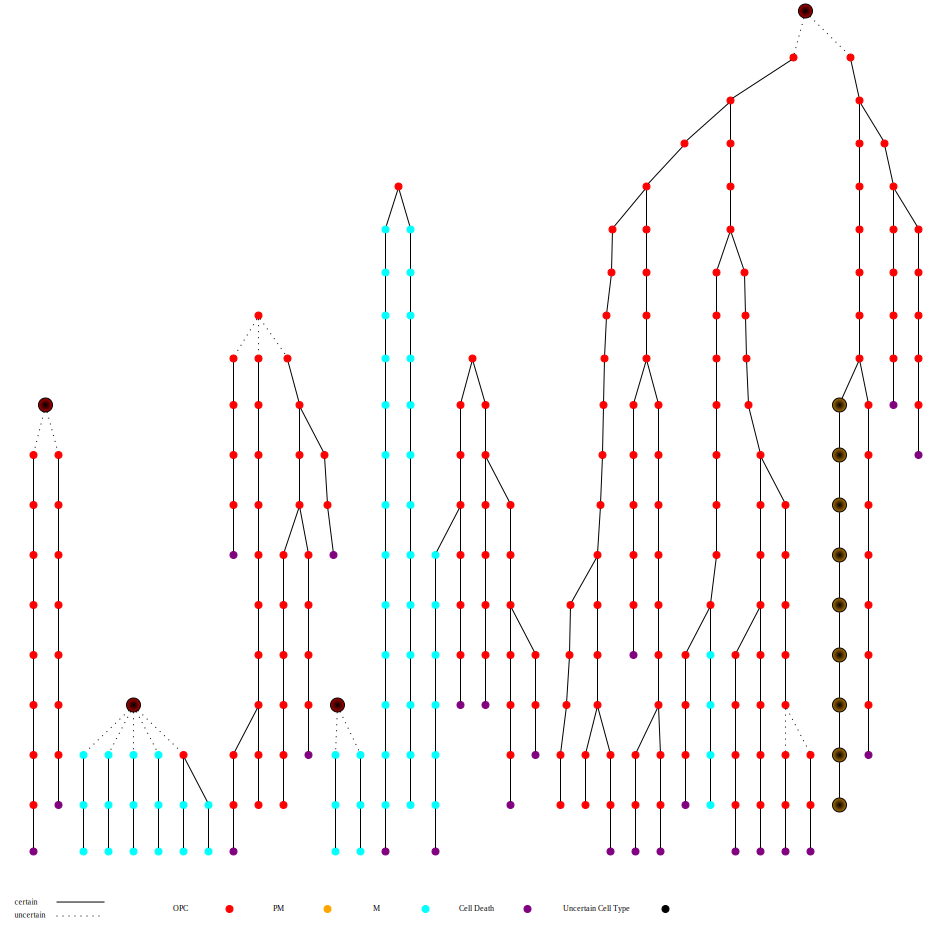

In [18]:
f

## Save the lineage
* To save the lineage as PDF (default), run the cell below.
* To save in another format, edit the cell creating the graph i.e.
``f = graphviz.Digraph(comment='Lineage', format='pdf')``
* Replace the ``format`` attribute by ``png`` or ``svg`` for example, and re-run the cells generating the graph.

The lineage is saved in the ``home`` directory, to download it 
* Go to the ``home`` directory
* Select the checkbox next to the file.
* Click ``Download`` in the menu bar that shows up when 

In [19]:
home = expanduser("~")
f.view(home+"/lineage_%s" % imageId)

'/home/jmarie/lineage_13425213.pdf'

### License (BSD 2-Clause) 

Copyright (C) 2021 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.